# Import necessary packages

In [43]:
import qiskit as q
import pec_module as pec
import importlib
import numpy as np
# import ace_tools as tools
import matplotlib as plt
from itertools import product
from numpy.linalg import inv
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

In [38]:
!pip show ace-tools

# Connect to ibm select the device to mimic the error

In [2]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
QiskitRuntimeService.save_account(
        channel="ibm_quantum_platform",
        token=token,
        instance=instance,
        set_as_default=True,
        overwrite=True
    )
device_name = "kingston"
dev = "ibm_" + device_name
service = QiskitRuntimeService()
device = service.backend(dev)
noise_model = NoiseModel.from_backend(device)

In [3]:
# # # Load saved credentials
# # service = QiskitRuntimeService()

# # #For real Device
# # device = service.backend("ibm_kyiv")
# # noise_model = NoiseModel.from_backend(device)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# # Get coupling map from backend
# coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

# #For Aer
# # backend = AerSimulator(noise_model=noise_model,
# #                        coupling_map=coupling_map,
# #                        basis_gates=basis_gates)
# backend = AerSimulator()

# backendqubitNum = backend.num_qubits
# print(backendqubitNum)

In [4]:
# 建立空的 noise model
noise_model = NoiseModel()

# 加入 CNOT gate 的 depolarizing noise（以 (0,1) 為例）
cx_error = depolarizing_error(param=0.05, num_qubits=2)  # 1% depolarizing error
noise_model.add_quantum_error(cx_error, 'cx', [0, 1])

# 加入 measurement 的 readout error（以 qubit 0 為例）
readout_probs = [[0.95, 0.05], [0.02, 0.98]]  # 機率轉換矩陣
readout_error = ReadoutError(readout_probs)
noise_model.add_readout_error(readout_error, [0])
noise_model.add_readout_error(readout_error, [1])

# 設定模擬器
backend = AerSimulator(noise_model=noise_model)
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


In [5]:
print("=== All gate errors in the noise model ===")
for (gate, qubits), errors in noise_model._local_quantum_errors.items():
    print(f"Gate: {gate}, Qubits: {qubits}")
    for err in errors:
        print(err)

print("\n=== All readout errors in the noise model ===")
for qubits, err in noise_model._local_readout_errors.items():
    print(f"Qubits: {qubits}, Error: {err}")


=== All gate errors in the noise model ===
Gate: c, Qubits: x
(0, 1)

=== All readout errors in the noise model ===
Qubits: (0,), Error: ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.95 0.05]
 P(j|1) =  [0.02 0.98]
Qubits: (1,), Error: ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.95 0.05]
 P(j|1) =  [0.02 0.98]


# Do 2-qubits measurement PEC

In [6]:
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg = QuantumRegister(2, 'q')
creg = ClassicalRegister(2, 'c')
q0_init = {}
q1_init = {}

for i in range (2):
    #rho0 state |0>
    InitCirZero = QuantumCircuit(qreg, creg)
    #rho1 state |1>
    InitCirOne = QuantumCircuit(qreg, creg)
    InitCirOne.x(i)
    #rho2 state |0>+|1>
    InitCirPlus = QuantumCircuit(qreg, creg)
    InitCirPlus.h(i)
    #rho3 state |0>+i|1>
    InitCirRight = QuantumCircuit(qreg, creg)
    InitCirRight.h(i)
    InitCirRight.s(i)
    
    if i == 0:
        q0_init = {'q0zero':InitCirZero, 'q0one':InitCirOne, 'q0plus':InitCirPlus, 'q0right':InitCirRight}
    else:
        q1_init = {'q1zero':InitCirZero, 'q1one':InitCirOne, 'q1plus':InitCirPlus, 'q1right':InitCirRight}

# Store the initial circuits in a dictionary
InitialState = {}
for q0, q0state in q0_init.items():
    for q1, q1state in q1_init.items():
        initcomb = q.circuit.QuantumCircuit.compose(q0state, q1state)
        InitialState.update({f'{q0}_{q1}':initcomb})

In [7]:
# Store the measurement circuits in a dictionary
Measurement = {}
pau = ['I', 'X', 'Y', 'Z']
for i in pau:
    for j in pau:
        # meascomb = Pauli('I' * (backendqubitNum-2) + j + i) 
        meascomb = Pauli(j + i) 
        Measurement.update({f'meas{j}{i}':meascomb})
print(Measurement)

{'measII': Pauli('II'), 'measXI': Pauli('XI'), 'measYI': Pauli('YI'), 'measZI': Pauli('ZI'), 'measIX': Pauli('IX'), 'measXX': Pauli('XX'), 'measYX': Pauli('YX'), 'measZX': Pauli('ZX'), 'measIY': Pauli('IY'), 'measXY': Pauli('XY'), 'measYY': Pauli('YY'), 'measZY': Pauli('ZY'), 'measIZ': Pauli('IZ'), 'measXZ': Pauli('XZ'), 'measYZ': Pauli('YZ'), 'measZZ': Pauli('ZZ')}


In [8]:
job = {}
estimator = Estimator(mode=backend)
estimator.options.default_shots = 100000
for MeasName, Measure in Measurement.items():
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0)
        job.update({f'{InitName}_{MeasName}':estimator.run([(CirTran, Measure)])})

In [9]:
result_origin = []
for index, job_name in job.items():
    res = job_name.result()
    result_origin.append(res[0].data.evs)
result_origin

[array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(-0.03280967),
 array(-0.02840972),
 array(0.90388096),
 array(-0.02724973),
 array(-0.02862971),
 array(-0.03246968),
 array(0.90230098),
 array(-0.0298897),
 array(-0.02914971),
 array(-0.03218968),
 array(0.900341),
 array(-0.02864971),
 array(-0.0303897),
 array(-0.03398966),
 array(0.90108099),
 array(-0.02764972),
 array(-0.03502965),
 array(-0.03252967),
 array(-0.02598974),
 array(0.900141),
 array(-0.03078969),
 array(-0.02636974),
 array(-0.02840972),
 array(0.90080099),
 array(-0.0301297),
 array(-0.03294967),
 array(-0.03498965),
 array(0.89900101),
 array(-0.03260967),
 array(-0.03102969),
 array(-0.0297897),
 array(0.89934101),
 array(0.89842102),
 array(-0.95796042),
 array(-0.03138969),
 array(-0.02376976),
 array(0.90134099),
 array(-0.9597004),
 array(-0.0302097),
 array(-0

In [10]:
g = np.array(result_origin).reshape(16, 16)
g

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-3.28096719e-02, -2.84097159e-02,  9.03880961e-01,
        -2.72497275e-02, -2.86297137e-02, -3.24696753e-02,
         9.02300977e-01, -2.98897011e-02, -2.91497085e-02,
        -3.21896781e-02,  9.00340997e-01, -2.86497135e-02,
        -3.03896961e-02, -3.39896601e-02,  9.01080989e-01,
        -2.76497235e-02],
       [-3.50296497e-02, -3.25296747e-02, -2.59897401e-02,
         9.00140999e-01, -3.07896921e-02, -2.63697363e-02,
        -2.84097159e-02,  9.00800992e-01, -3.01296987e-02,
        -3.29496705e-02, -3.49896501e-02,  8.99001010e-01,
        -3.26096739e-02, -3.10296897e-02, -2.97897021e-02,
         8.99341007e-01],
       [ 8.98421016e-01, -9.57960420e

In [11]:
#Create State Preparation Matrix A
A_single = np.array([[1, 1, 1, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [1,-1, 0, 0]])
A = np.kron(A_single, A_single)
#print(A)

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
#print(A_inv)
B = np.matmul(g, A_inv)
B_inv = inv(B)
# print(B_inv)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])
a = {'I':a_i, 'X':a_x, 'Y':a_y, 'Z':a_z}
aa = {}
qq = {}
for f, first in a.items():
    for s, second in a.items():
        a_mix = np.kron(first, second)
        aa.update({f'a_{s}{f}':a_mix})
        q_mix = np.matmul(a_mix, B_inv)
        qq.update({f'{s}{f}':q_mix})
        
        # print(f'a_{f}{s}:', a_mix)
        # print(f'{f}{s}:', q_mix)
        # print('\n')
print(qq)

{'II': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'XI': array([[ 3.27326866e-02,  1.07114680e+00, -2.45196882e-03,
         8.41582692e-05,  1.40039563e-04,  3.26177850e-03,
        -4.61364901e-05, -2.02785713e-03,  1.70347092e-03,
         4.97338055e-04, -3.13369180e-03, -2.38948162e-03,
         2.90268073e-05, -9.90924502e-04, -1.67189999e-03,
         2.57026131e-03]]), 'YI': array([[ 3.34942741e-02, -4.34736769e-03,  1.07336015e+00,
         1.80015485e-03,  6.29450520e-04,  9.18126712e-03,
         1.24827744e-03, -3.83624373e-03,  7.99646265e-04,
         2.47271205e-03,  6.17709522e-04, -1.17295247e-03,
         2.74889059e-03, -4.69400570e-03, -2.80086556e-03,
        -6.13526008e-04]]), 'ZI': array([[ 3.17545380e-02,  1.58058645e-03, -2.48892096e-03,
         1.07605595e+00,  1.31504302e-03,  2.43594245e-03,
        -2.77859941e-03,  5.17434457e-04,  9.62914597e-04,
        -2.31747734e-03,  3.65860443e-03, -3.44528563e-04,
         2.2294757

In [12]:
#Observable = Oq1 Oq0
Observable = ['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ']
IdealMeasurement = {}
for obs in Observable:
    # IdealObservable = SparsePauliOp(['I' * (backendqubitNum)], coeffs=[qq[obs][0][0]])
    IdealObservable = SparsePauliOp(['II'], coeffs=[qq[obs][0][0]])
    for i in range(1, len(Observable)):
        # IdealObservable += SparsePauliOp([('I' * (backendqubitNum-2) + Observable[i])], coeffs=[qq[obs][0][i]])
        IdealObservable += SparsePauliOp([(Observable[i])], coeffs=[qq[obs][0][i]])
    IdealMeasurement.update({obs:IdealObservable})
IdealMeasurement

{'II': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
  0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 'XI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[ 3.27326866e-02+0.j,  1.07114680e+00+0.j, -2.45196882e-03+0.j,
   8.41582692e-05+0.j,  1.40039563e-04+0.j,  3.26177850e-03+0.j,
  -4.61364901e-05+0.j, -2.02785713e-03+0.j,  1.70347092e-03+0.j,
   4.97338055e-04+0.j, -3.13369180e-03+0.j, -2.38948162e-03+0.j,
   2.90268073e-05+0.j, -9.90924502e-04+0.j, -1.67189999e-03+0.j,
   2.57026131e-03+0.j]),
 'YI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[ 3.34942741e-02+0.j, -4.34736769e-03+0.j,  1.07336015e+00+0.j,
   1.80015485e-03+0.j,  6.29450

In [13]:
len(IdealMeasurement)

16

# Do 2-qubits Cnot PEC - Build PTM of the Ideal Ucnot 

In [30]:
#Construct Ideal Ucnot
pauli = ["I", "X", "Y", "Z"]
pauli_pair = {}
pauli_pair_for_circuit = {}
for i in pauli:
    for j in pauli:
        pauli_pair.update({f"{i}{j}":np.array(Pauli(f"{i}{j}").to_matrix())})
        pauli_pair_for_circuit.update({f"{j}{i}":np.array(Pauli(f"{j}{i}").to_matrix())})

def evolution(gate, state):
    return np.matmul(np.matmul(gate, state), np.conj(gate).T)
        
Cnot = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0 ,0, 0, 1],
                 [0, 0, 1, 0]])
IdealCnot = np.ones((16,16),  dtype=complex)
i = 0
for index1, matrix1 in pauli_pair.items():
    j = 0
    for index2, matrix2 in pauli_pair.items():
        applycnot = evolution(Cnot, matrix1)
        element = np.matmul(matrix2, applycnot)
        IdealCnot[i][j] = np.round(np.trace(element)/4)
        j+=1
    i+=1 

print(IdealCnot)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

# Pauli Twirling

In [31]:
pauli_transfer = {}
for channel, matrix in pauli_pair_for_circuit.items():
    new_matrix = evolution(Cnot, matrix)
    for new_channel, comp_matrix in pauli_pair.items():
        if np.array_equal(new_matrix, comp_matrix) or np.array_equal(new_matrix, -comp_matrix):
            pauli_transfer.update({channel:new_channel})
print(pauli_transfer)

{'II': 'II', 'XI': 'XX', 'YI': 'YX', 'ZI': 'ZI', 'IX': 'IX', 'XX': 'XI', 'YX': 'YI', 'ZX': 'ZX', 'IY': 'ZY', 'XY': 'YZ', 'YY': 'XZ', 'ZY': 'IY', 'IZ': 'ZZ', 'XZ': 'YY', 'YZ': 'XY', 'ZZ': 'IZ'}


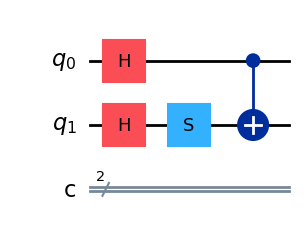

In [32]:
# Function to generate measurement circuits
def generate_pauli_circuits(index):
    circuits = {
        "I": QuantumCircuit(2, 2),
        "X": QuantumCircuit(2, 2),
        "Y": QuantumCircuit(2, 2),
        "Z": QuantumCircuit(2, 2),
    }
    # X-measurement
    circuits["X"].h(index)
    # Y-measurement
    circuits["Y"].h(index)
    circuits["Y"].s(index)
    

    return circuits

#Cnot gate
Cnotgate = QuantumCircuit(qreg, creg)
Cnotgate.cx(0, 1)

# Store the measurement circuits in a dictionary
PauliTwirling = {}
for q0_label, q0 in generate_pauli_circuits(0).items():
    for q1_label, q1 in generate_pauli_circuits(1).items():
        pauli_comb = q.circuit.QuantumCircuit.compose(q0, q1)
        AddCnot = q.circuit.QuantumCircuit.compose(pauli_comb, Cnotgate)
        PauliTwirling.update({f"{q0_label}{q1_label}": AddCnot})
PauliTwirling["XY"].draw("mpl")

In [33]:
Twirling_job = {}
for pauli, circuit in PauliTwirling.items():
    CirTran = q.compiler.transpile(circuit, backend=backend, optimization_level=0)
    MeasureIndex = pauli_transfer[pauli]
    Twirling_job.update({pauli:estimator.run([(CirTran, IdealMeasurement[MeasureIndex])])})
Twirling_job

{'II': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf6de6e0>,
 'IX': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf687c10>,
 'IY': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf600460>,
 'IZ': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf8a4a90>,
 'XI': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf3fcb50>,
 'XX': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf3fde40>,
 'XY': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf853fd0>,
 'XZ': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf87d0c0>,
 'YI': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52c0028b80>,
 'YX': <qiskit_ibm_runtime.fake_provider.local_runtime_job.LocalRuntimeJob at 0x7f52bf7e4610>,
 'YY': <qiskit_ibm_runtime.fake_provider.local_run

In [35]:
fidelity = []
i = 0
for pauli, job_name in Twirling_job.items():
    res = job_name.result()
    fidelity.append(res[0].data.evs)
    i = i + 1
fidelity

[array(1.),
 array(0.00634976),
 array(0.00983516),
 array(0.95335493),
 array(0.94498188),
 array(0.9524682),
 array(0.95115505),
 array(-0.95790681),
 array(0.95537285),
 array(-0.00182884),
 array(0.00410279),
 array(0.9591899),
 array(0.95231368),
 array(0.00653876),
 array(-0.00410859),
 array(0.94757175)]

In [41]:
import numpy as np
# Define the standard 4-element 1-qubit Hadamard matrix (normalized)
H1 = np.array([[1, 1], [1, -1]]) / 2
H2 = np.kron(H1, H1)  # 4x4
H4 = np.kron(H2, H2)  # 16x16

# Compute the Pauli channel coefficients c
c = H4 @ fidelity
print(c)
print(sum(c))


[ 0.4799619   0.1217447   0.12206263  0.23939787  0.00583516 -0.11521407
 -0.11788626  0.24178448  0.00256787  0.12221855  0.12135756 -0.23682014
  0.00402003 -0.11621657 -0.11474401  0.23993029]
1.0000000000000002


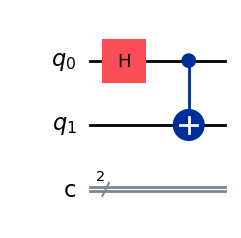

In [46]:
CX = QuantumCircuit(2, 2)
CX.h(0)
CX.cx(0, 1)
CX.draw("mpl")

In [47]:
CX_trpl = q.compiler.transpile(circuit, backend=backend, optimization_level=0)
CX_job = estimator.run([(CX_trpl, IdealMeasurement["ZZ"])])

In [48]:
CX_res = CX_job.result()
CX_result = CX_res[0].data.evs
CX_result

array(0.94990963)

In [50]:
c_inv = 1/c
print(np.dot(c_inv, fidelity))

756.6864767518884


In [ ]:
def OutputMatrix(matrix, filename):
    # 將每列轉為空格分隔的字串
    matrix_lines = [''.join(f"{val:>9.5f}" for val in row) for row in matrix]
    
    # 繪製圖片
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')  # 不顯示座標軸
    
    # 建立表格
    table_data = []
    for i in range(16):
        row = []
        for j in range(16):
            val = matrix[i][j]
            formatted = f"{val.real:.6f}"
            row.append(formatted)
        table_data.append(row)
    
    # 建立表格物件
    table = ax.table(cellText=table_data,  loc='center',  cellLoc='center')
    
    # 樣式調整
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            cell = table[i, j]
            val = matrix[i][j]
            
            # 主對角線粗體
            if 0.8 <= abs(val) < 1.2:
                cell.set_text_props(weight='bold')
    
            # 紅色標註：介於 0.01 ~ 0.1 或 -0.01 ~ -0.1
            if 0.01 <= abs(val) < 0.1:
                cell.set_text_props(color='red')
    
    # 儲存為圖片
    plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
    plt.close()

In [ ]:
OutputMatrix(Avg_gateError, "Avg_gateError_1Wshots")

In [ ]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_TwirlingError.csv'
np.savetxt(filename, Avg_gateError, delimiter=",", fmt="%.10e")

In [ ]:
result = np.diag(Avg_gateError).reshape(16, 1).astype(complex)

In [ ]:
P = np.array([[1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],\
              [1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1],\
              [1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],\
              [1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1],\
              [1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1],\
              [1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1],\
              [1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],\
              [1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1],\
              [1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1],\
              [1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1],\
              [1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1],\
              [1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1],\
              [1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1],\
              [1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1],\
              [1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1],\
              [1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1]])
P

In [ ]:
weight_c = np.matmul(inv(P), result)
weight_c

In [ ]:
# 重新初始化結果陣列
inv_result = np.zeros(16, dtype=complex)

#  
for i in range(16):
        inv_result[i] += inv(Avg_gateError)[i, i]
inv_result = inv_result.reshape(16, 1)
inv_result

In [ ]:
inv_weight_c = np.matmul(inv(P), inv_result)
inv_weight_c

In [ ]:
Twirling_test_circuit_set = {}
for InitName, Initial in InitialState.items():
    Twirling_test_circuit = {}
    for firstPauli, secondPauli in pauli_transfer.items():
        AddPauli = q.circuit.QuantumCircuit.compose(Initial, PauliTwirling[firstPauli])
        AddCnot = q.circuit.QuantumCircuit.compose(AddPauli, Cnotgate)
        Twirling_test_circuit.update({firstPauli:AddCnot})
    Twirling_test_circuit_set.update({InitName:Twirling_test_circuit})

In [ ]:
Twirling_test_job = {}
for MeasName, Measure in IdealMeasurement.items():
    for InitName, circuit_set in Twirling_test_circuit_set.items():
        job = {}
        for pauli, Cir in circuit_set.items():
            CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
            job.update({pauli:estimator.run([(CirTran, Measure)])})
        Twirling_test_job.update({f'{InitName}_{MeasName}':job})

In [ ]:
Twirling_test_job

In [ ]:
g_twirling = []
for index, job_name in Twirling_test_job.items():
    average_result = 0
    i = 0
    for pauli, job_set in job_name.items():
        res = job_set.result()
        average_result = average_result + res[0].data.evs * inv_weight_c[i]
        i += 1
    # print(average_result)
    g_twirling.append(average_result)
g_twirling = np.array(g_twirling).reshape(16, 16)
Cnot_twirling = np.matmul(np.matmul(B_inv, g_twirling), A_inv)
print('g:\n', g_twirling)
print('Cnot:\n', Cnot_twirling)

In [ ]:
# 轉換成 float array
NoisyExpectation = np.array([x.item() for x in NoisyExpectation])
MitigateExpectation = np.array([x.item() for x in MitigateExpectation])

# bin 設定：以 0 為中心對稱
bin_width = 0.005
max_val = max(abs(NoisyExpectation).max(), abs(MitigateExpectation).max())
bins = np.arange(-np.ceil(max_val * 100) / 100 - bin_width, np.ceil(max_val * 100) / 100 + bin_width, bin_width)

# 統計量
mean_Error = np.mean(NoisyExpectation)
median_Error = np.median(NoisyExpectation)
std_Error = np.std(NoisyExpectation)
var_Error = np.var(NoisyExpectation)
mean_Mitigate = np.mean(MitigateExpectation)
median_Mitigate = np.median(MitigateExpectation)
std_Mitigate = np.std(MitigateExpectation)
var_Mitigate = np.var(MitigateExpectation)

# 統計 bin 中數據
error_hist, _ = np.histogram(NoisyExpectation, bins=bins)
Mitigate_hist, _ = np.histogram(MitigateExpectation, bins=bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
fig, ax = plt.subplots(figsize=(12, 6))
width = bin_width * 0.45

# 繪製直方圖
ax.bar(bin_centers - width/2, error_hist, width=width, label='Noisy', color='cornflowerblue')
ax.bar(bin_centers + width/2, Mitigate_hist, width=width, label='Mitigated', color='mediumseagreen')

# 平均值虛線
ax.axvline(mean_Error, color='blue', linestyle='--')
ax.axvline(mean_Mitigate, color='green', linestyle='--')
ax.axvline(1, color='red', linestyle='-')

# Legend
error_patch = mpatches.Patch(color='cornflowerblue', label='Noisy')
mitigate_patch = mpatches.Patch(color='mediumseagreen', label='Mitigated')
error_line = mlines.Line2D([], [], color='blue', linestyle='--', label=f'Noisy Mean: {mean_Error:.4f}')
mitigate_line = mlines.Line2D([], [], color='green', linestyle='--', label=f'Mitigated Mean: {mean_Mitigate:.4f}')
ax.legend(handles=[error_patch, mitigate_patch, error_line, mitigate_line], loc='upper center')

# X軸間距、座標、範圍
xticks = np.arange(np.floor(bin_centers.min()*200)/200, np.ceil(bin_centers.max()*200)/200 + bin_width, bin_width)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{x:.3f}' for x in xticks], rotation=45)
all_values = np.concatenate([NoisyExpectation, MitigateExpectation])
ax.set_xlim(all_values.min() - bin_width, all_values.max() + bin_width)

# x, y軸 label
ax.set_xlabel('Expectation Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram (Bin Centered at 0 with Interval Labels)')
ax.grid(True)

# 統計資訊的位置參數 & 文字、邊框設定
text_error_position = (min(NoisyExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())) 
text_mitigate_position = (min(NoisyExpectation.min(), MitigateExpectation.min()), max(error_hist.max(), Mitigate_hist.max())*0.8)
bbox_props_error = dict(boxstyle="round,pad=0.4", edgecolor='cornflowerblue', facecolor='white', linewidth=1)
bbox_props_mitigate = dict(boxstyle="round,pad=0.4", edgecolor='mediumseagreen', facecolor='white', linewidth=1)
ax.text(*text_error_position, f'Median: {median_Error:.4f}\nVariance: {var_Error:.4f}\nStd Dev: {std_Error:.4f}',
        color='cornflowerblue', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_error)
ax.text(*text_mitigate_position, f'Median: {median_Mitigate:.4f}\nVariance: {var_Mitigate:.4f}\nStd Dev: {std_Mitigate:.4f}',
        color='mediumseagreen', fontsize=10, fontweight='bold', verticalalignment='top', horizontalalignment='left', bbox=bbox_props_mitigate)

#圖形呈現、儲存
# histogram_path = f"0707_Real_{device_name}_{round}_qubit{qubit}.png"
plt.tight_layout()
# plt.savefig(histogram_path, dpi=500, bbox_inches='tight')
plt.show()
plt.close()
# histogram_path